# Mentoria: "Detección de Objetos en Imágenes" de la Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus aplicaciones - Año: 2020.

## Grupo 2: 
 * Maria Florencia Caballero
 * Joel Vivas
 * Leonardo Rodriguez
 * Diego Gonzalez 

# Desarrollo del trabajo correspondiente a la materia: "**Analisis y Visualización de Datos**"

In [36]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import os
os.chdir('/content/drive/My Drive/Mentoria')

In [38]:
from IPython.display import Image as Imge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import PIL
from PIL import Image
from os import path
from scipy import stats


from google.colab.patches import cv2_imshow #en Colab!

import seaborn as sns

In [39]:
data_sets_path = "/content/drive/My Drive/Mentoria"
os.chdir('{}'.format(data_sets_path))

# Análisis General

A continuación cargamos todos los archivos de datos disponibles y los concatenamos en un único dataset. Agregamos tres columnas más a los datos, que indican respectivamente el momento del día que se tomó la imágen (Mañana, Tarde y Noche), el tamaño de la misma y el tipo de dataset (test o training).

In [40]:
os.chdir('{}'.format(data_sets_path))

def path(day_time, size, typ):
    return ("{path}/Dataset-{time}/{size}"
    "/{time}-{size}-Labels_{typ}.csv").format(path=data_sets_path,
                                              time=day_time, size=size, typ=typ)
def build_df(day_time, size, typ):
    ds = pd.read_csv(path(day_time, size, typ))
    ds['Time'] = day_time
    ds['Size'] = size
    ds['Type'] = typ
    return ds
    
types = ["train", "test"]
day_time_list = ["M", "T", "N"]
size_list = ["G", "P"]
frames = [build_df(t, s, typ) for t in day_time_list for s in size_list for typ in types]
total_data = pd.concat(frames, ignore_index=True)
total_data["Hand_Pixel_Width"]  = (total_data["xmax"] - total_data["xmin"])
total_data["Hand_Pixel_Height"] = (total_data["ymax"] - total_data["ymin"])
total_data["Area"] = total_data["Hand_Pixel_Width"] * total_data["Hand_Pixel_Height"]
total_data

,filename,width,height,class,xmin,ymin,xmax,ymax,Time,Size,Type,Hand_Pixel_Width,Hand_Pixel_Height,Area
0,M_G_Trabajando_Mano-Verde_7.jpg,1920,1080,hand,877,262,1121,422,M,G,train,244,160,39040
1,M_G_Trabajando_Mano-Verde_7.jpg,1920,1080,hand,1104,121,1266,278,M,G,train,162,157,25434
2,M_G_Trabajando_Verdes_170.jpg,1920,1080,hand,1001,332,1329,613,M,G,train,328,281,92168
3,M_G_Trabajando_Verdes_170.jpg,1920,1080,hand,1233,289,1353,395,M,G,train,120,106,12720
4,M_G_Trabajando_Manos_28.jpg,1920,1080,hand,812,219,944,320,M,G,train,132,101,13332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15198,N_P_Trabajando_Manos_155.jpg,1920,1080,hand,980,246,1028,298,N,P,test,48,52,2496
15199,N_P_Trabajando_Manos_155.jpg,1920,1080,hand,1073,235,1128,285,N,P,test,55,50,2750
15200,N_P_Trabajando_Amarillos_229.jpg,1920,1080,hand,993,193,1051,249,N,P,test,58,56,3248
15201,N_P_Trabajando_Amarillos_229.jpg,1920,1080,hand,1058,212,1112,270,N,P,test,54,58,3132


El dataset completo tiene 15203 filas y 14 columnas:

In [41]:
total_data.shape

(15203, 14)

A continuación mostramos la cantidad de imágenes disponibles según el momento del día en que fueron generadas.

In [42]:
total_data.groupby([total_data.Time]).count()["filename"]

Time
M    5442
N    5026
T    4735
Name: filename, dtype: int64

Si separamos por el tipo de dataset (training vs test), obtenemos las siguientes cantidades:

In [43]:
total_data.groupby([total_data.Time, total_data.Size, total_data.Type]).count()["filename"]

Time  Size  Type 
M     G     test      838
            train    1998
      P     test      733
            train    1873
N     G     test      691
            train    1696
      P     test      759
            train    1880
T     G     test      753
            train    1820
      P     test      616
            train    1546
Name: filename, dtype: int64

A modo de resumen graficamos las cantidas totales. Primero agrupadas por el momento del día y luego separado por training/test.

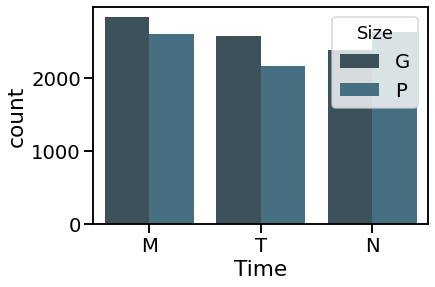

In [44]:
sns.countplot(x="Time", hue="Size", data=total_data, palette=sns.color_palette("GnBu_d"))

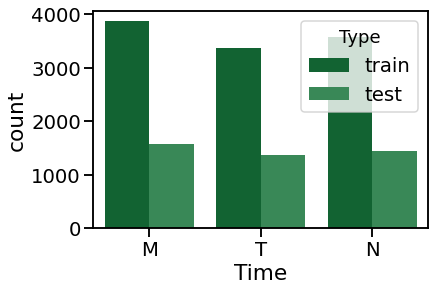

In [45]:
sns.countplot(x="Time", hue="Type", data=total_data, palette=sns.color_palette("BuGn_r"))

A partir de estos gráficos podemos ver que los conjuntos de datos están equilibrados en cuanto a cantidad de imágenes de acuerdo al momento del día en que fueron obtenidas. Lo que si difieren un poco en cuanto a la cantidad de imágenes con objetos grandes y pequeños. Para su correcta utilizacióón deberían estar equilibrados.

En relación a la cantidad de datos de "test" y "train", se observa que sigue la regla de dividir el conjunto de datos en un 80% para entrenamiento y 20% para validacióón. 


Buscamos la imagen con menor/mayor área en la sección que contiene el guante o mano:

In [46]:
max_row_index = total_data["Area"].idxmax()
min_row_index = total_data["Area"].idxmin()

In [47]:
max_area_row = total_data.loc[max_row_index]
min_area_row = total_data.loc[min_row_index]

compara = pd.concat([max_area_row, min_area_row], axis=1,keys=["Imagen con Mayor Area", 'Imagen con Menor Area'], names = "Caracteristicas")

display(compara)

Caracteristicas,Imagen con Mayor Area,Imagen con Menor Area
filename,M_G_Mostrando_Amarillos_137.jpg,M_P_Trabajando_Manos_262.jpg
width,1920,1920
height,1080,1080
class,hand,hand
xmin,863,1034
ymin,399,252
xmax,1414,1053
ymax,872,277
Time,M,M
Size,G,P


Ahora lo hacemos segun el Tipo.



In [48]:
max_row_index = total_data[total_data.Type == 'train'].Area.idxmax()
min_row_index =total_data[total_data.Type == 'train'].Area.idxmin()
max_area_row = total_data[total_data.Type == 'train'].loc[max_row_index]
min_area_row = total_data[total_data.Type == 'train'].loc[min_row_index]

compara = pd.concat([max_area_row, min_area_row], axis=1,keys=["Imagen con Mayor Area", 'Imagen con Menor Area'], names = "Caracteristicas Type = 'train'")

display(compara)

Caracteristicas Type = 'train',Imagen con Mayor Area,Imagen con Menor Area
filename,N_G_Mostrando_Manos_43.jpg,M_P_Trabajando_Manos_262.jpg
width,1920,1920
height,1080,1080
class,hand,hand
xmin,497,1034
ymin,475,252
xmax,875,1053
ymax,822,277
Time,N,M
Size,G,P


In [49]:
max_row_index = total_data[total_data.Type == 'test'].Area.idxmax()
min_row_index =total_data[total_data.Type == 'test'].Area.idxmin()
max_area_row = total_data[total_data.Type == 'test'].loc[max_row_index]
min_area_row = total_data[total_data.Type == 'test'].loc[min_row_index]

compara = pd.concat([max_area_row, min_area_row], axis=1,keys=["Imagen con Mayor Area", 'Imagen con Menor Area'], names = "Caracteristicas Type = 'test'")

display(compara)

Caracteristicas Type = 'test',Imagen con Mayor Area,Imagen con Menor Area
filename,M_G_Mostrando_Amarillos_137.jpg,M_P_Trabajando_Manos_352.jpg
width,1920,1920
height,1080,1080
class,hand,hand
xmin,863,869
ymin,399,266
xmax,1414,900
ymax,872,288
Time,M,M
Size,G,P


Analizamos las dimensiones de los rectángulos que enmarcan a los guantes/manos:

In [50]:
width = total_data["Hand_Pixel_Width"].describe()
height = total_data["Hand_Pixel_Height"].describe()
compara = pd.concat([width, height], axis=1,keys=["Ancho", 'Largo'], names = "Rectangulos")

display(compara)

Rectangulos,Ancho,Largo
count,15203.000000,15203.000000
mean,126.914885,118.890877
std,78.174071,75.926498
min,18.000000,18.000000
25%,56.000000,50.000000
50%,114.000000,107.000000
75%,188.000000,174.000000
max,551.000000,538.000000


# Análisis Estadístico

Se nos provee de un dataset de training que corresponde con imágenes de tipo G tomadas durante la mañana. Este dataset contiene 2048 features de las cuáles desconocemos su significado preciso, que estan enumeradadas del 0 al 2047. Mostramos un fragmento de ese dataset a continuación.

In [51]:
def read_file(path):
  ds = pd.read_csv(path, low_memory=False)
  ds = ds.drop(['Unnamed: 0'], axis=1) 
  return ds

dataset_train_MG = read_file('Dataset-M/G/train/dataset/csv_wlabels_train_MG_df.csv')
dataset_train_MG

,filename,xmin,xmax,ymin,ymax,day_time,size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Mano-Amarillo_0_double_box2.jpg,436,662,273,474,M,G,si,amarillo,1.192934,0.132554,0.292861,0.704324,0.043486,0.561370,0.492875,0.415565,0.606461,0.405709,0.532783,0.382000,0.859358,0.157759,0.539070,0.180152,0.087641,0.451658,0.067623,0.188491,0.273504,0.352612,0.365537,0.085581,0.049281,0.534786,0.346597,0.729510,0.327267,0.175310,0.214354,...,0.109618,0.201162,0.053464,0.400421,1.828703,0.766772,0.345443,0.320869,0.876834,1.105888,0.360420,0.137844,0.201754,0.184912,1.058968,0.694844,0.348436,0.221967,1.842808,0.593052,0.208990,0.419584,0.467739,0.847367,0.767512,0.429070,0.462808,0.097680,0.373019,0.055480,0.850606,0.618605,0.579222,0.214956,1.543457,0.240321,0.015946,0.498210,0.105096,0.415124
1,M_G_Mostrando_Mano-Amarillo_10_double_box2.jpg,307,503,227,357,M,G,si,amarillo,0.473153,0.326438,0.872934,0.272843,0.581942,0.085599,0.116944,1.393549,0.868530,0.557496,0.077261,0.120294,0.248606,0.222858,0.037286,0.110815,0.024490,0.304910,0.080512,0.987467,0.256264,0.208748,0.706314,0.027361,0.048373,0.121103,0.151871,0.414459,0.020769,0.036364,0.139919,...,0.114571,0.486142,0.007770,0.081066,0.650191,1.732524,0.107846,0.190294,0.139264,0.262592,0.818040,0.411074,0.561725,0.178695,1.652464,0.323930,0.114231,0.034584,0.112140,0.549182,0.521623,0.479088,0.086294,0.663143,0.556707,0.101734,0.252282,0.200444,0.193105,0.226180,0.327536,0.041440,0.610802,0.714450,1.010661,0.164083,0.489083,0.401081,0.334849,0.009120
2,M_G_Mostrando_Mano-Amarillo_11_double_box2.jpg,304,503,162,351,M,G,si,amarillo,0.551692,0.311296,0.630988,0.612515,0.324043,0.122678,0.292788,1.080067,0.315567,0.291490,0.299222,0.343937,0.387980,0.095756,0.041759,0.252472,0.021887,0.390645,0.009959,0.159158,0.046286,0.517520,0.329951,0.015500,0.208366,0.207085,0.477750,1.682721,0.211059,0.136033,0.004871,...,0.202850,0.283488,0.004961,0.331641,1.339007,1.408519,0.366572,0.162958,0.096853,0.572625,0.727882,0.139311,0.394578,0.234353,1.004670,0.320588,0.795888,0.018158,0.721928,0.496969,0.381788,0.381119,0.520868,0.709025,0.796566,0.022527,0.436449,0.095957,0.142214,0.054401,0.399043,0.194232,0.255874,0.506477,1.049478,0.093706,0.237381,0.270804,0.206780,0.021252
3,M_G_Mostrando_Mano-Amarillo_12_double_box2.jpg,320,516,102,308,M,G,si,amarillo,0.445529,1.104021,0.329798,0.772140,0.191984,0.092597,0.323702,0.493198,0.260759,0.254920,0.351949,0.659263,0.447098,0.195273,0.218607,0.268113,0.177694,0.234917,0.034185,1.457397,0.243114,0.227982,0.109678,0.034942,0.022739,0.370361,0.388175,1.431276,0.508981,0.182964,0.028220,...,0.342891,0.395380,0.000000,1.146170,2.406389,1.542115,0.599406,0.682540,0.349439,0.375349,0.910304,0.101252,0.310441,0.259261,0.752298,0.508452,1.337586,0.117757,0.462209,0.567773,0.316124,0.120465,0.518646,0.852264,0.879169,0.088652,0.956650,0.038115,0.170151,0.015820,0.151291,0.084338,0.546983,0.239140,0.521701,0.121823,0.056032,0.503652,0.516597,0.325798
4,M_G_Mostrando_Mano-Amarillo_13_double_box2.jpg,323,507,76,291,M,G,si,amarillo,0.401482,1.118310,0.485366,0.686955,0.046806,0.203579,0.343371,0.685662,0.365654,0.238447,0.164747,0.638464,0.357792,0.310761,0.130233,0.190511,0.145574,0.047850,0.008097,0.955863,0.202188,0.456735,0.175217,0.003151,0.091389,0.384982,0.245546,1.183161,0.610042,0.135109,0.068913,...,0.183034,0.248365,0.004623,1.021811,1.633345,1.578439,0.513223,0.543867,0.239947,0.230462,0.854492,0.106203,0.446704,0.263999,0.866798,0.268687,1.261234,0.019139,0.585002,0.505261,0.361614,0.125756,0.382490,1.262282,0.557245,0.088643,1.130196,0.005393,0.386618,0.028207,0.361752,0.200909,0.574926,0.532086,0.517593,0.025498,0.058469,0.502583,0.073139,0.072178
...,...,...,...,...,...,...,...,...,.

La siguiente descripción del dataset incluye la media, la desviación estándar y los cuartiles de cada feature.

In [52]:
dataset_train_MG.describe()

,xmin,xmax,ymin,ymax,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,...,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,771.657816,974.319138,258.218938,433.529058,0.477770,0.331842,0.445396,0.373106,0.219712,0.266277,0.432418,0.929838,0.555243,0.265715,0.323893,0.245734,0.473116,0.351616,0.216477,0.141867,0.208300,0.391411,0.406250,0.228911,0.188195,0.379157,0.539597,0.322744,0.241840,0.317191,0.278264,0.620548,0.213563,0.159680,0.193713,0.304085,0.242244,0.308130,0.313400,0.150645,...,0.395579,0.200528,0.075142,0.475661,1.288574,1.274743,0.167222,0.303251,0.430871,0.618949,0.389508,0.247155,0.190523,0.157521,0.733245,0.405542,0.502956,0.183366,0.899037,0.519834,0.175979,0.347612,0.241890,0.495322,0.757072,0.200101,0.433913,0.271685,0.409189,0.134600,0.539357,0.418268,0.352605,0.269870,0.869333,0.272479,0.221077,0.261720,0.217420,0.253174
std,322.755374,317.190835,114.742089,143.397632,0.367963,0.261997,0.347320,0.286808,0.198534,0.226057,0.315389,0.418831,0.365728,0.195801,0.250399,0.290876,0.352024,0.251262,0.174546,0.128747,0.216942,0.269424,0.370876,0.252726,0.171419,0.250389,0.442542,0.327718,0.269646,0.208702,0.239106,0.412825,0.175200,0.150416,0.172410,0.304076,0.176697,0.233776,0.206846,0.144169,...,0.311965,0.150707,0.088064,0.330557,0.749176,0.610341,0.152124,0.277516,0.291269,0.351078,0.302060,0.209879,0.148432,0.113736,0.576239,0.273691,0.373283,0.167314,0.499653,0.284278,0.166945,0.261882,0.184747,0.312581,0.340874,0.204811,0.418447,0.260211,0.228247,0.141702,0.327215,0.420016,0.312070,0.233409,0.450767,0.212012,0.205468,0.188005,0.227270,0.183336
min,0.000000,307.000000,0.000000,128.000000,0.000390,0.000000,0.000000,0.000268,0.000000,0.000000,0.000000,0.065238,0.000000,0.000932,0.000000,0.000000,0.000000,0.001869,0.000000,0.000000,0.000000,0.002415,0.001510,0.000000,0.000000,0.001431,0.003762,0.000000,0.000000,0.000000,0.000000,0.000757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001140,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012937,0.098471,0.000000,0.000000,0.003355,0.000412,0.000635,0.000000,0.000000,0.000000,0.000076,0.000000,0.000644,0.000000,0.030766,0.025648,0.000000,0.000088,0.000000,0.003396,0.042753,0.000000,0.000000,0.000000,0.008218,0.000000,0.003120,0.000000,0.000000,0.000000,0.028360,0.000000,0.000000,0.000000,0.000000,0.000000
25%,553.000000,747.750000,176.750000,322.750000,0.205745,0.136916,0.195043,0.165223,0.073274,0.099189,0.195196,0.601902,0.283189,0.121615,0.142872,0.069243,0.221102,0.171811,0.083302,0.046032,0.055697,0.187238,0.132023,0.063270,0.060963,0.197824,0.206759,0.094862,0.052130,0.163287,0.109996,0.322128,0.082701,0.051307,0.067601,0.097395,0.108273,0.145583,0.161522,0.048113,...,0.170465,0.088007,0.014220,0.236299,0.675619,0.805388,0.061588,0.110731,0.219984,0.356615,0.162219,0.093307,0.080304,0.069624,

Para facilitar el análisis de los datos, trabajaremos solamente con las features "más importantes" clasificadas según un algoritmo de selección. Calculamos cuales son las features de mayor correlación con la columna *guantes*, que es la que querríamos predecir, y nos quedamos con las 5 mejores. Para ello usamos el algoritmo *SelectKBest* provisto por la librería *sklearn*. Se utilizó en este caso un test estadístico *chi2*, que resultó en la selección de las features mostradas a continuación.

In [53]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = dataset_train_MG
data.guantes = data.guantes.apply(lambda has: 1 if has == "si" else 0)
X = data.iloc[:,9:]
#independent columns
y = data.iloc[:,7]    #target column i.e "guantes"
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe column
selected = featureScores.nlargest(5,'Score')
worst_features = featureScores.nsmallest(3, 'Score')
selected

,Specs,Score
481,481,543.761386
1118,1118,384.295152
707,707,367.749080
1933,1933,356.018378
164,164,352.436830


Graficamos la distribución de probabilidad de features seleccionadas:

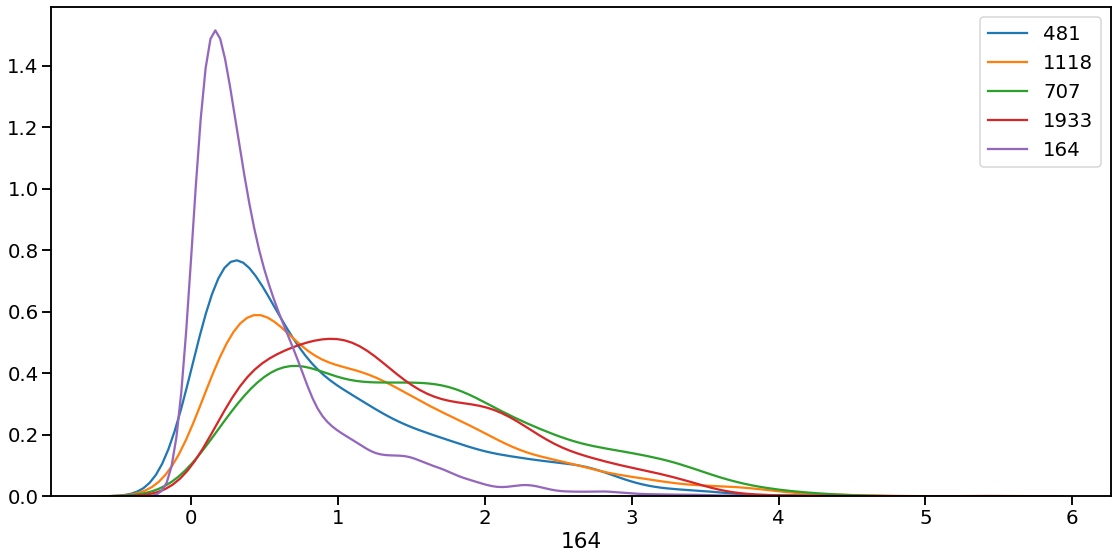

In [54]:
plt.figure(figsize=(19,9))
for i in selected.index:
    sns.distplot(data[str(i)], label=str(i),  kde=True, hist=False)
plt.legend()

Se muestra en la siguiente tabla el rango de valores que toma cada feature seleccionada.

In [55]:
columns = [str(i) for i in selected.index]

ranges = pd.DataFrame()
ranges['min'] = data[columns].min()
ranges['max'] = data[columns].max()
ranges['range'] = data[columns].max() - data[columns].min()
ranges


,min,max,range
481,0.000000,4.314620,4.314620
1118,0.003005,4.694402,4.691397
707,0.014325,4.434217,4.419892
1933,0.025020,5.376831,5.351811
164,0.000000,3.672178,3.672178


Observamos en el siguiente gráfico que la feature de mayor puntaje, la *481*, obtiene valores significativamente diferenciados según se trate de imágenes
*con* o *sin* guantes.

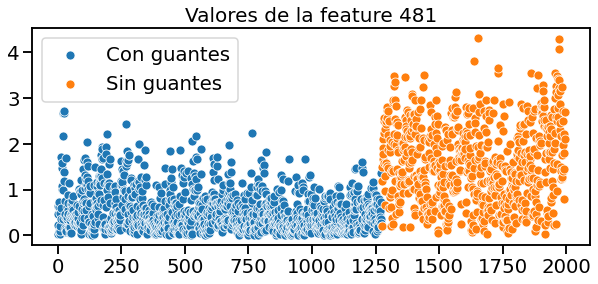

In [56]:
plt.figure(figsize=(10,4))
sns.set_context(context='talk', font_scale=1.2)
feature = "481"
plot1 = sns.scatterplot(data=data[data.guantes == 1][feature], label="Con guantes")
sns.scatterplot(data=data[data.guantes == 0][feature], label="Sin guantes")
plot1.axes.set_title("Valores de la feature {}".format(feature),fontsize=20)
plt.legend()

Los scatterplot para las otras cuatro features son:


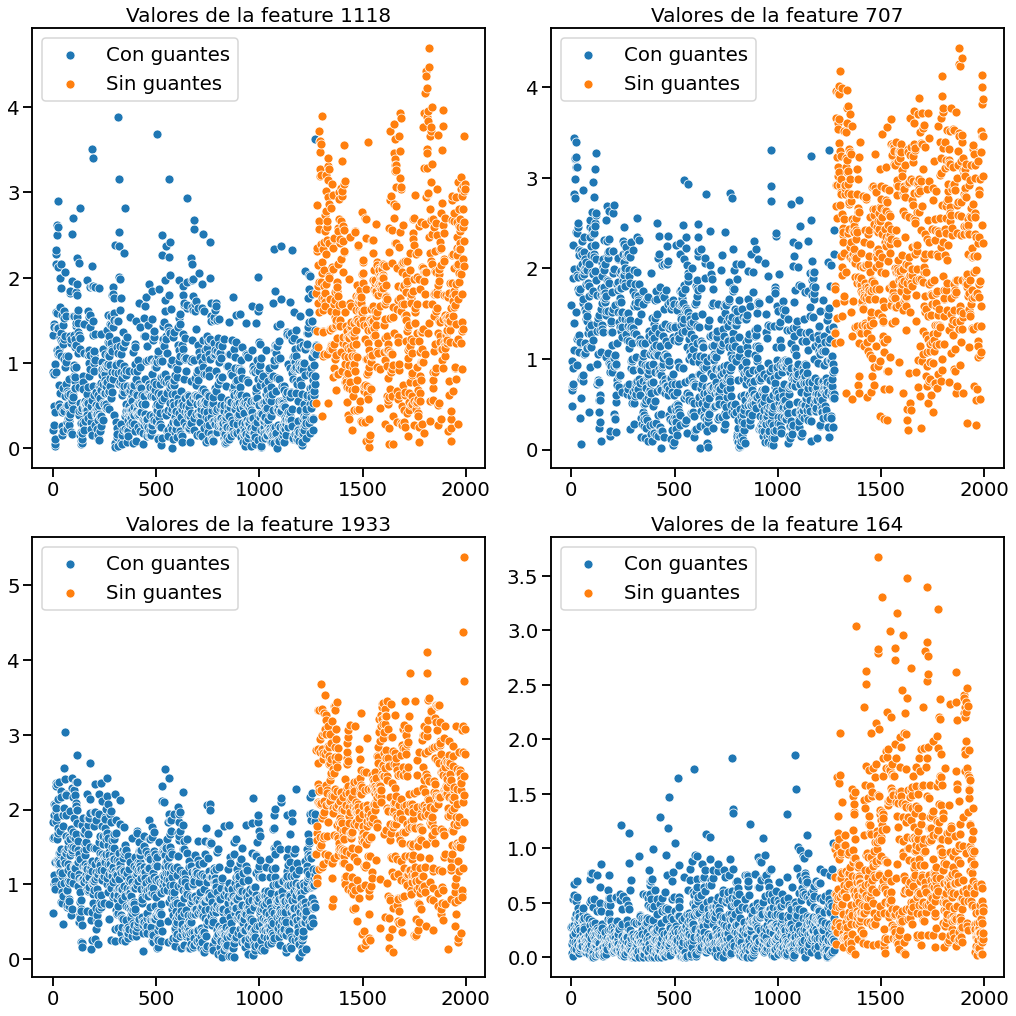

<Figure size 720x432 with 0 Axes>

In [57]:
coordenadas = ['1118','707','1933','164']
num_plots = len(coordenadas)
total_cols = 2
total_rows = 2
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
sns.set_context(context='talk', font_scale=1.2)
plt.figure(figsize=(10,6))

for i, var in enumerate(coordenadas):   
    row = i//total_cols
    pos = i % total_cols   
    ploti = sns.scatterplot(data=data[data.guantes == 1][var], ax=axs[row][pos], label="Con guantes")
    sns.scatterplot(data=data[data.guantes == 0][var], ax=axs[row][pos],label="Sin guantes")
    ploti.axes.set_title("Valores de la feature {}".format(var),fontsize=20)
    

Del mismo modo se puede apreciar que la distribución de la feature *481* también registra diferencias apreciables entre los dos grupos de imágenes.

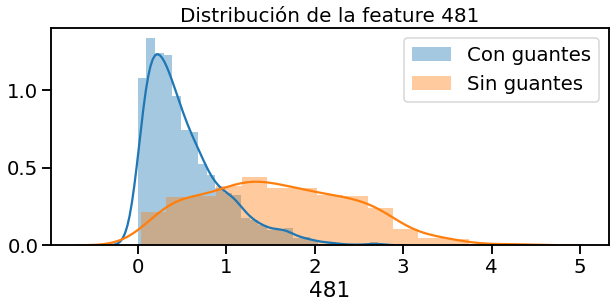

In [58]:
plt.figure(figsize=(10,4))
feature = "481"
plot1 = sns.distplot(data[data.guantes == 1][feature], label="Con guantes")
sns.distplot(data[data.guantes == 0][feature], label="Sin guantes")
plot1.axes.set_title("Distribución de la feature {}".format(feature),fontsize=20)
plt.legend()

In [59]:
data[["filename"]].groupby(data.color).count()

,filename
color,
amarillo,587
mano,721
verde,688


Si expandimos el análisis a las 5 features principales podemos ver que este comportamiento se mantiene en las features 1018 y 164. Las 2 features restantes parecieran tomar más en cuenta el color del guante que el hecho de que el guante exista o no, demostrandose 3 distribuciones claramente diferenciadas en las features 707 y 1933.

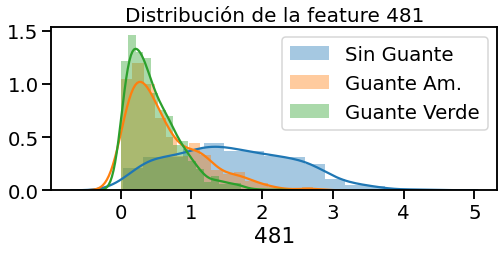

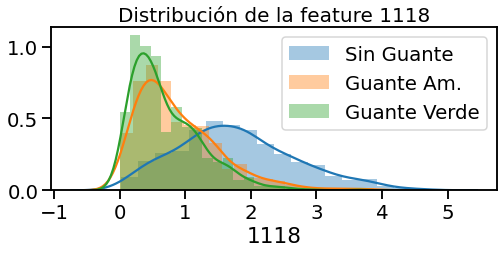

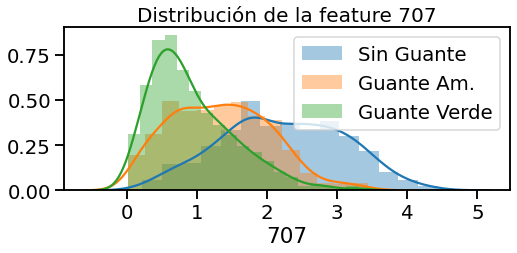

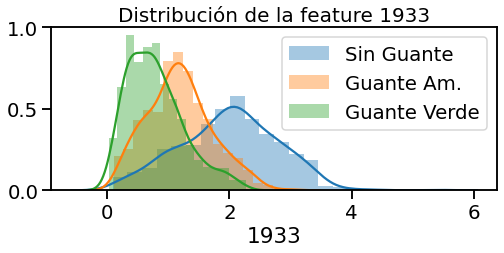

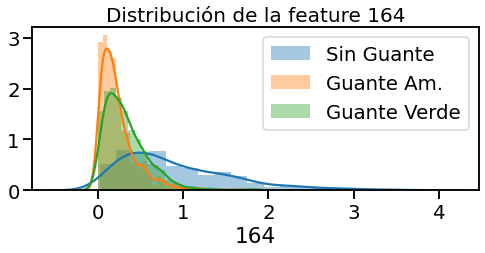

In [60]:
for i in selected.index:
    feature = selected.Specs[i]
    plt.figure(figsize=(8,3))
    plot = sns.distplot(data[data.color == "mano"][feature], label="Sin Guante")
    sns.distplot(data[data.color == "amarillo"][feature], label="Guante Am.")
    sns.distplot(data[data.color == "verde"][feature], label="Guante Verde")
    plot.axes.set_title("Distribución de la feature {}".format(feature),fontsize=20)
    plot.legend()

En contraste, si realizamos el mismo análisis dentro de las features peor calificadas, no se reflejan las diferentes clasificaciones en los datos (presentando los mismos distribuciones similares)

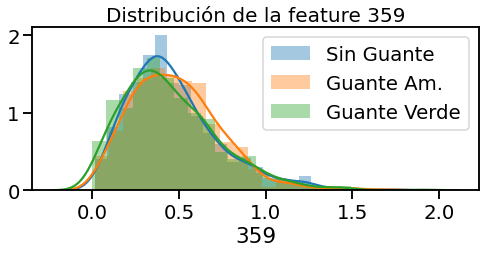

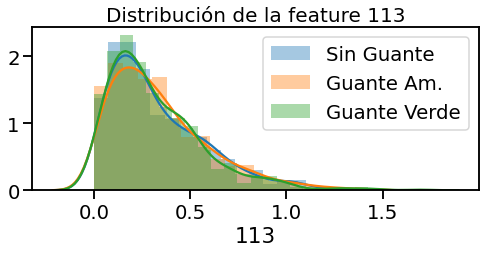

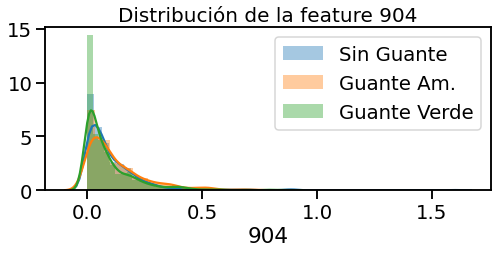

In [61]:
for i in worst_features.index:
    feature = worst_features.Specs[i]
    plt.figure(figsize=(8,3))
    plot = sns.distplot(data[data.color == "mano"][feature], label="Sin Guante")
    sns.distplot(data[data.color == "amarillo"][feature], label="Guante Am.")
    sns.distplot(data[data.color == "verde"][feature], label="Guante Verde")
    plot.axes.set_title("Distribución de la feature {}".format(feature),fontsize=20)
    plot.legend()


Analizaremos ahora qué información podemos obtener de las coordenadas en las que se encuentran ubicados los guantes. Como primer paso, creamos un pairplot para obtener una idea cualitativa de las relaciones entre las variables de coordenadas de la mano y las features seleccionadas como las mas importantes.



Text(0.5, 0.98, '\nCorrelacion entre las features seleccionadas y las coordenadas de posicion de las manos\n')

<Figure size 720x432 with 0 Axes>

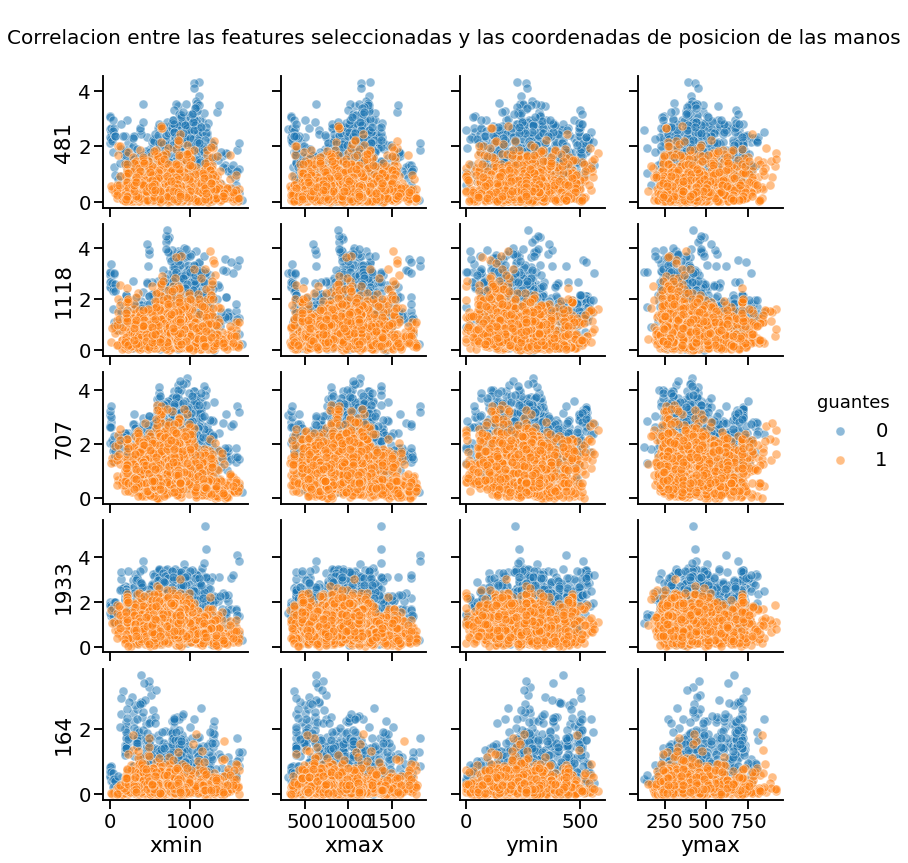

In [62]:
sns.set_context(context='talk', font_scale=1.2)
plt.figure(figsize=(10,6))
g=sns.pairplot(data=dataset_train_MG, x_vars=["xmin", "xmax", "ymin", "ymax"], y_vars=['481','1118','707','1933','164'], hue='guantes', plot_kws= {'alpha': 0.5})
plt.subplots_adjust(top=0.9)
g.fig.subplots_adjust(top=0.9)
g.fig.set_size_inches(12,12)
g.fig.suptitle('\nCorrelacion entre las features seleccionadas y las coordenadas de posicion de las manos\n', fontsize=20)

A simple vista, podemos ver que no habría una relación aparente entre las coordenadas de posición de las manos y las features seleccionadas como las mas importantes.
Procedemos a analizar la distribución de las variables de coordenadas para tener una idea de que test de correlación podemos aplicar.



Analizamos cualitativamente las distribuciones de las cuatro variables de coordenadas, a partir de los siguientes histogramas.

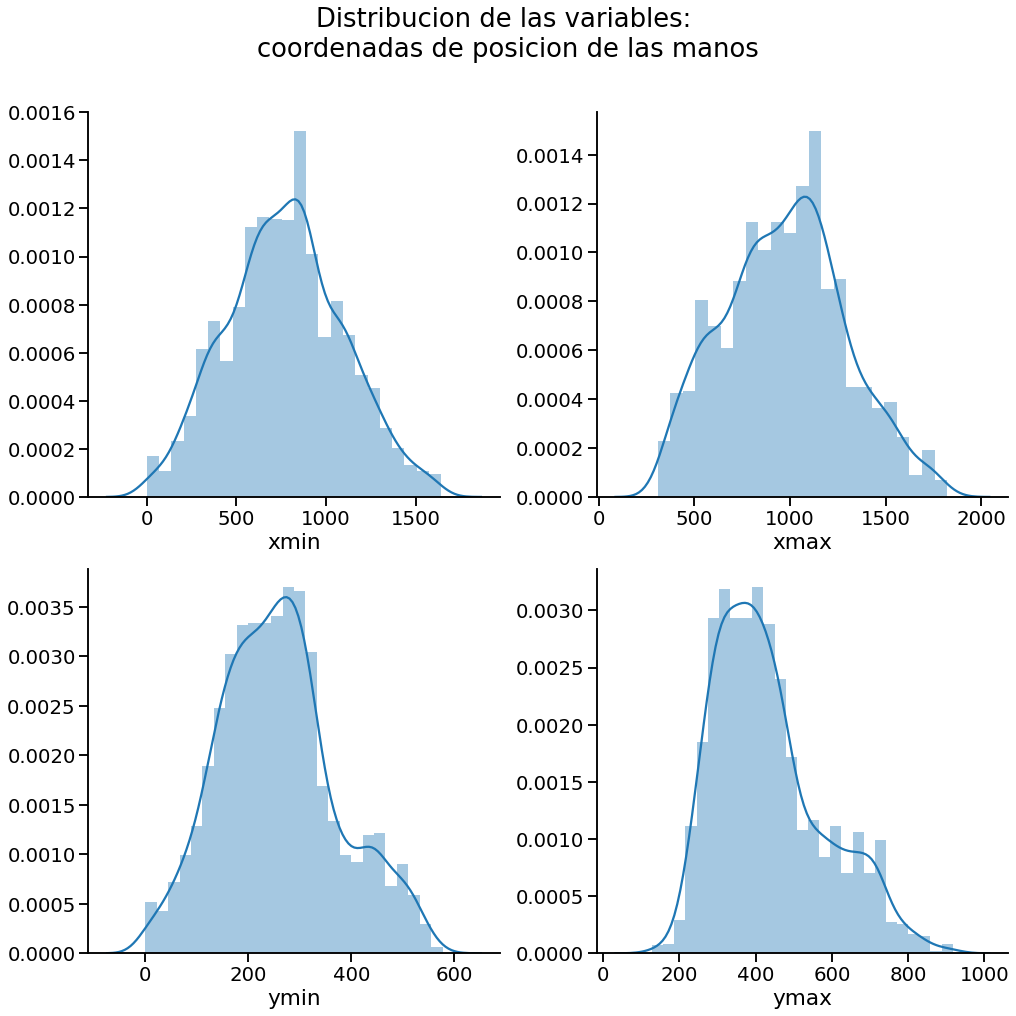

In [63]:
coordenadas = ['xmin','xmax','ymin','ymax']
num_plots = len(coordenadas)
total_cols = 2
total_rows = 2
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
fig.suptitle('Distribucion de las variables: \ncoordenadas de posicion de las manos\n')

for i, var in enumerate(coordenadas):   
    row = i//total_cols
    pos = i % total_cols
    plot = sns.distplot(dataset_train_MG[var], ax=axs[row][pos])
    sns.despine()
    
   
   
  
    
    

Chequeamos cuantitativamente a traves de kstests. Concluimos que solo podemos aceptar la hipotesis nula para la coordenada en x y aceptar que se aproxima en ambos casos a una distribución normal con un p-valor mayor al 5% en ambos casos (mayor al nivel de significancia 0.05), por lo cual decidimos aplicar un test de correlación por coeficiente de Pearson para estas variables.


En el caso de las coordenadas en y (ymin e ymax) no podemos aproximar sus respectivas distribuciones con distribuciones normales ya que obtenemos p-valores muy bajos, por lo que para estas variables decidimos aplicar un test de correlacion por coeficiente de Spearman.

In [64]:
#Aplicamos la funcion kstest de scipy para cada variable seteando los argumentos de una distribucion normal
#con media y varainza iguales a las de la variable respectiva
test1 = stats.kstest(dataset_train_MG.xmin,'norm', args=(dataset_train_MG.xmin.mean(), dataset_train_MG.xmin.std()), N= dataset_train_MG.xmin.count())
test2 = stats.kstest(dataset_train_MG.xmax,'norm', args=(dataset_train_MG.xmax.mean(), dataset_train_MG.xmax.std()), N= dataset_train_MG.xmax.count())
test3 = stats.kstest(dataset_train_MG.ymin,'norm', args=(dataset_train_MG.ymin.mean(), dataset_train_MG.ymin.std()), N= dataset_train_MG.ymin.count())
test4 = stats.kstest(dataset_train_MG.ymax,'norm', args=(dataset_train_MG.ymax.mean(), dataset_train_MG.ymax.std()), N= dataset_train_MG.ymax.count())
cols = ['Kstest_xmin','Kstest_xmax','Kstest_ymin','Kstest_ymax']
tests = [test1[1],test2[1],test3[1],test4[1]]
dict = {}
dftests = pd.DataFrame(dict, index = ["Pvalue"], columns = ['Kstest_xmin','Kstest_xmax','Kstest_ymin','Kstest_ymax'])
for i in range(4):
  dftests.loc["Pvalue",cols[i]] = tests[i]

dftests

,Kstest_xmin,Kstest_xmax,Kstest_ymin,Kstest_ymax
Pvalue,0.23339,0.069778,0.00115086,2.6495e-13


Realizamos las tablas de correlación y creamos heatmaps para visualizarlas mejor

In [65]:
xcolumns = ['xmin', 'xmax','481','1118','707','1933','164']

correlx = dataset_train_MG[xcolumns]
display(correlx.corr('pearson'))


,xmin,xmax,481,1118,707,1933,164
xmin,1.000000,0.986185,0.039501,0.080578,-0.005444,-0.036366,-0.114466
xmax,0.986185,1.000000,0.046863,0.078304,-0.004507,-0.035766,-0.130117
481,0.039501,0.046863,1.000000,0.715001,0.694090,0.651468,0.263419
1118,0.080578,0.078304,0.715001,1.000000,0.704805,0.668171,0.143979
707,-0.005444,-0.004507,0.694090,0.704805,1.000000,0.789135,0.258138
1933,-0.036366,-0.035766,0.651468,0.668171,0.789135,1.000000,0.316514
164,-0.114466,-0.130117,0.263419,0.143979,0.258138,0.316514,1.000000


In [66]:
ycolumns = ['ymin','ymax','481','1118','707','1933','164']
correly = dataset_train_MG[ycolumns]
display(correly.corr('spearman'))

,ymin,ymax,481,1118,707,1933,164
ymin,1.000000,0.952398,0.151849,-0.056330,0.040257,0.114871,0.116960
ymax,0.952398,1.000000,0.167171,-0.053878,0.021352,0.112549,0.095138
481,0.151849,0.167171,1.000000,0.756339,0.715981,0.674550,0.256918
1118,-0.056330,-0.053878,0.756339,1.000000,0.732526,0.742138,0.238497
707,0.040257,0.021352,0.715981,0.732526,1.000000,0.804326,0.302171
1933,0.114871,0.112549,0.674550,0.742138,0.804326,1.000000,0.311867
164,0.116960,0.095138,0.256918,0.238497,0.302171,0.311867,1.000000


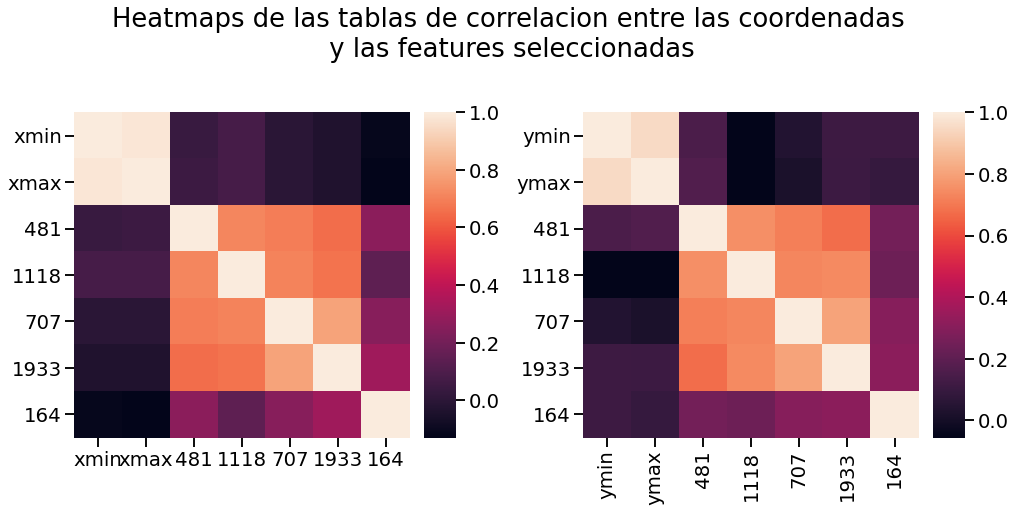

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(7*2, 7), constrained_layout=True)
fig.suptitle('Heatmaps de las tablas de correlacion entre las coordenadas\n y las features seleccionadas\n')
sns.heatmap(correlx.corr('pearson'), annot=False, ax=axs[0])
sns.heatmap(correly.corr('spearman'), annot=False, ax=axs[1])

    

Concluimos que no hay correlación entre las variables de las coordenadas de posición de las manos y las features seleccionadas como las mas importantes. Sin embargo, podemos observar en los heatmaps una cierta correlacion entre las features entre si.

### Distribución de las features seleccionadas, test de Kolmogorov


Vamos a analizar si las distribuciones de los datos de las carácteristicas poseen una distribución normal. Para ello vamos a aplicar el test de *Kolmogorov-Smirnov* a los datos. 

In [68]:
from sklearn import preprocessing
selected.index

Int64Index([481, 1118, 707, 1933, 164], dtype='int64')

#### Distribución para las **"features"** de ***manos sin guantes***:



Test Kolmogorv-Smirnov para manos sin guantes


,Feature,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,481,0.040447,1.839655e-01,0.993471,0.0,1.578701,0.851432,721
1,1118,0.044439,1.125295e-01,0.993419,0.0,1.775415,0.897651,721
2,707,0.042988,1.352599e-01,0.985399,0.0,2.221155,0.868211,721
3,1933,0.032483,4.274469e-01,0.997407,0.0,1.991783,0.795325,721
4,164,0.119459,2.012033e-09,0.993696,0.0,0.913282,0.660454,721


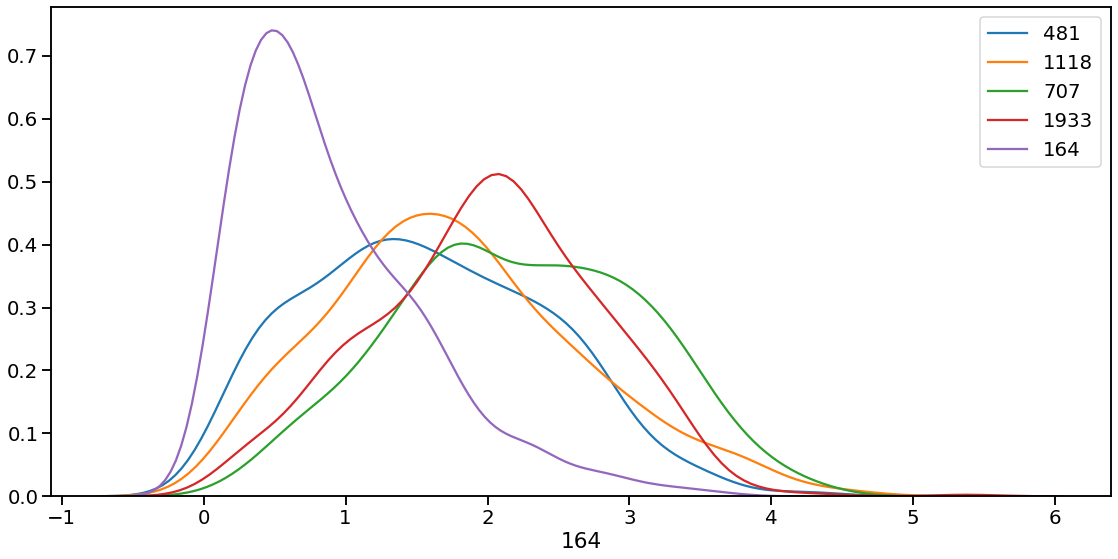

In [69]:
k_tests_sin_guante = []
plt.figure(figsize=(19,9))
for feature in selected.index:
    x     = data[data.guantes == 0][str(feature)]
    mu    = np.mean( x )
    std   = np.std( x )
    n     = len( x )
    #test  = [ (y - mu)/(std*np.sqrt(n)) for y in x ]
    #Normalizo
    #x_normalizado = preprocessing.normalize([x])
    x_normalizado = x
    mu    = np.mean( x_normalizado )
    std   = np.std(x_normalizado )
    n     = len( x_normalizado )
    sns.distplot(x_normalizado, label=str(feature),  kde=True, hist=False)

    #kolmogorv-s
    s, p  = stats.kstest(x_normalizado,'norm',args=(mu,std))
    #s, p  = stats.kstest(x_normalizado,'rayleigh',args=(0,mu))
    
    #Aproximo una mezcla de gaussianas
    gauss_kde    = stats.gaussian_kde(x)

    #Testeo
    s1, p1 = stats.kstest(x,gauss_kde)
    #print( feature, s1, p1 )

    k_tests_sin_guante.append( {
        'Feature': str(feature),
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
plt.legend()
k_tests_sin_guante_df = pd.DataFrame(k_tests_sin_guante)
print("Test Kolmogorv-Smirnov para manos sin guantes")
k_tests_sin_guante_df


Si analizamos los p-valores para cada una de las características y si asumimos un nivel de significancia de 0.05, podemos decir que no hay elementos suficientes para rechazar la hipótesis nula de que las distribuciones de los datos provienen de una distribución normal para todas las características excepto para la "**164**". 

Ahora vamos a realizar los gráficos Q-Q para ver cuanto se alejan de la distribución normal:

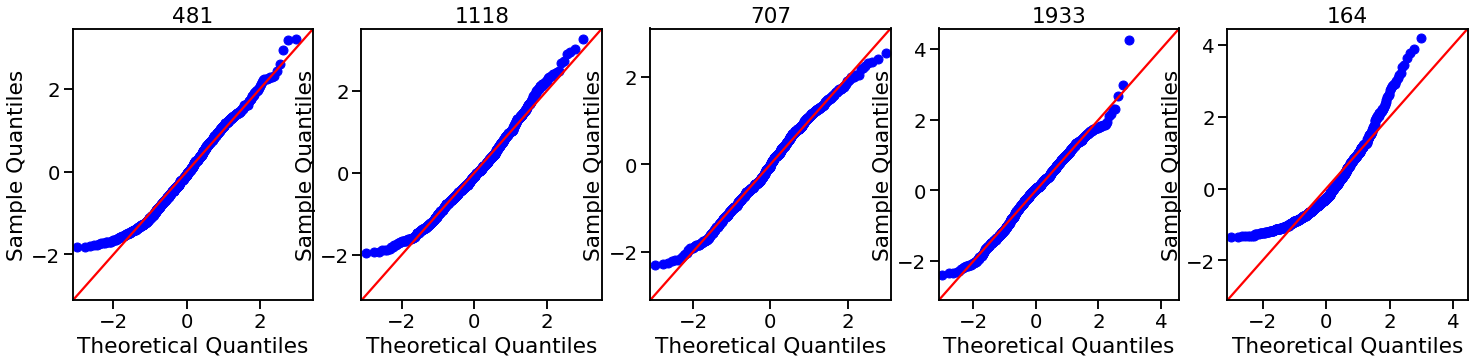

In [70]:
import statsmodels.api as sm

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25,5) )

i=0
for feature in selected.index:
    x = data[data.guantes == 0][str(feature)]
    fig1 = sm.qqplot(x,fit=True, line='45', ax=axs[i], scale=5)
    #tats.probplot(x, plot=axs[i])
    axs[i].set_title(feature)
    axs[i].set_aspect('auto')
    i = i+1
 
plt.show()

Como predijeron los resultados del K-S test, no se puede rechazar la hipotesis de que las "features" para ***manos sin guantes*** no provengan de una distribución normal, excepto para la **164**. 

#### Distribución para las **"features"** ***con*** ***guantes***:




Test Kolmogorv-Smirnov para manos con guantes


,Feature,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,481,0.118986,3.471501e-16,0.992929,0.0,0.539421,0.446028,1275
1,1118,0.113543,8.953156e-15,0.996375,0.0,0.795944,0.587396,1275
2,707,0.082542,5.269230e-08,0.988513,0.0,1.120233,0.682541,1275
3,1933,0.050538,2.862820e-03,0.997376,0.0,0.973514,0.533806,1275
4,164,0.125208,7.002161e-18,2.012893,0.0,0.286706,0.249452,1275


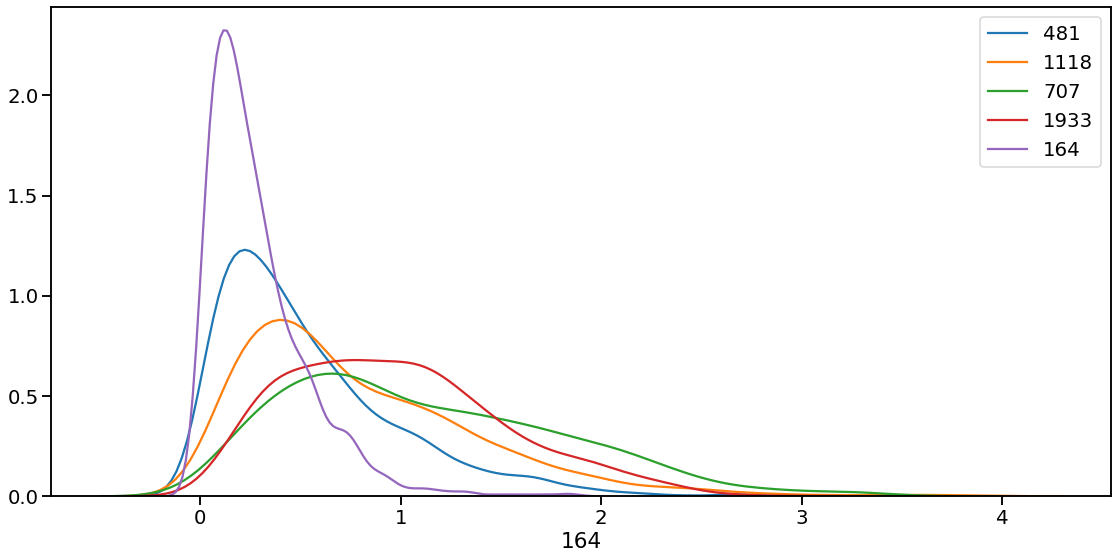

In [71]:
k_tests_con_guante = []
plt.figure(figsize=(19,9))
for feature in selected.index:
    x     = data[data.guantes == 1][str(feature)]
    mu    = np.mean( x )
    std   = np.std( x )
    n     = len( x )
    #test  = [ (y - mu)/(std*np.sqrt(n)) for y in x ]
    #Normalizo
    #x_normalizado = preprocessing.normalize([x])
    x_normalizado = x
    mu    = np.mean( x_normalizado )
    std   = np.std(x_normalizado )
    n     = len( x_normalizado )
    sns.distplot(x_normalizado, label=str(feature),  kde=True, hist=False)

    #kolmogorv-s
    s, p  = stats.kstest(x_normalizado,'norm',args=(mu,std))
    #s, p  = stats.kstest(x_normalizado,'rayleigh',args=(0,mu))
    
    #Aproximo una mezcla de gaussianas
    gauss_kde    = stats.gaussian_kde(x)

    #Testeo
    s1, p1 = stats.kstest(x,gauss_kde)
    #print( feature, s1, p1 )

    k_tests_con_guante.append( {
        'Feature': str(feature),
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
plt.legend()
k_tests_con_guante_df = pd.DataFrame(k_tests_con_guante)
print("Test Kolmogorv-Smirnov para manos con guantes")
k_tests_con_guante_df


Analizando los resultados de los p-valores podemos decir que se rechaza la hipótesis nula de que los datos provienen de una distribución normal.

Ahora vamos a realizar los gráficos Q-Q para ver cuanto se alejan de la distribución normal:

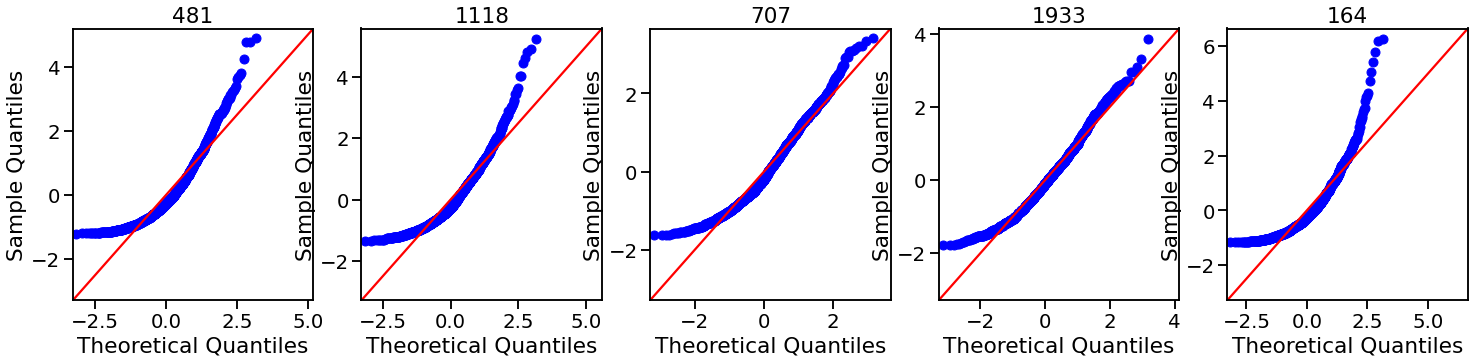

In [72]:
import statsmodels.api as sm

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25,5) )

i=0
for feature in selected.index:
    x = data[data.guantes == 1][str(feature)]
    fig1 = sm.qqplot(x,fit=True, line='45', ax=axs[i], scale=5)
    #tats.probplot(x, plot=axs[i])
    axs[i].set_title(feature)
    axs[i].set_aspect('auto')
    i = i+1
 
plt.show()

Como predijeron los resultados del K-S test, se puede rechazar la hipotesis de que las "features" para ***manos con guantes*** provengan de una distribución normal.

#### Distribución para las **"features"** con ***guantes amarillos***:




Test Kolmogorv-Smirnov para manos con guantes amarillos


,Feature,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,481,0.134165,1.124039e-09,0.985800,0.0,0.624183,0.512727,587
1,1118,0.109417,1.416221e-06,0.993447,0.0,0.891409,0.637008,587
2,707,0.050058,1.020188e-01,0.982144,0.0,1.341057,0.705165,587
3,1933,0.036219,4.185653e-01,0.994671,0.0,1.184683,0.531145,587
4,164,0.147433,1.335355e-11,2.371302,0.0,0.234333,0.222277,587


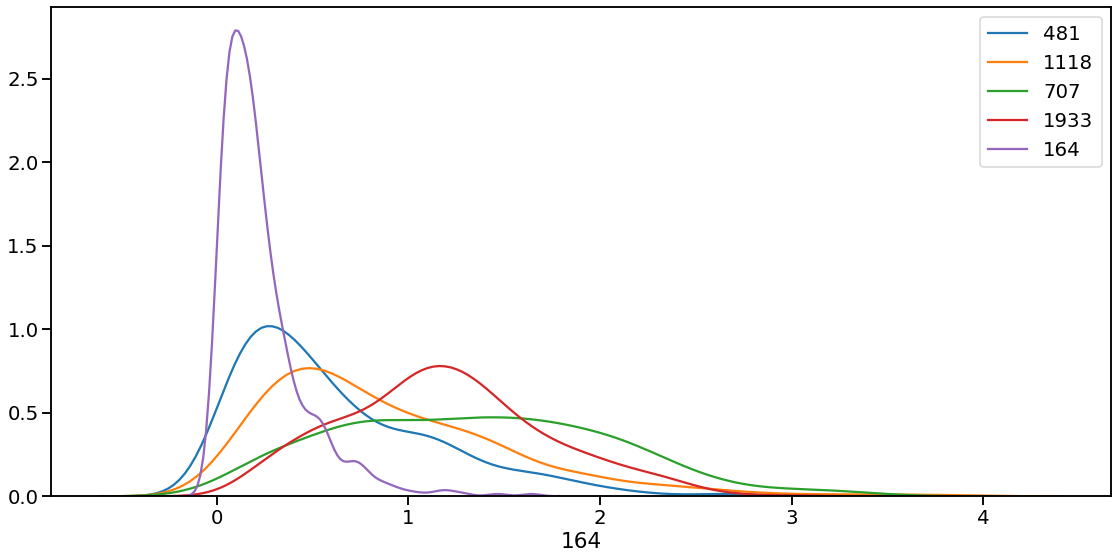

In [73]:
k_tests_con_guante = []
plt.figure(figsize=(19,9))
for feature in selected.index:
    x     = data[data.color == "amarillo"][str(feature)]
    mu    = np.mean( x )
    std   = np.std( x )
    n     = len( x )
    #test  = [ (y - mu)/(std*np.sqrt(n)) for y in x ]
    #Normalizo
    #x_normalizado = preprocessing.normalize([x])
    x_normalizado = x
    mu    = np.mean( x_normalizado )
    std   = np.std(x_normalizado )
    n     = len( x_normalizado )
    sns.distplot(x_normalizado, label=str(feature),  kde=True, hist=False)

    #kolmogorv-s
    s, p  = stats.kstest(x_normalizado,'norm',args=(mu,std))
    #s, p  = stats.kstest(x_normalizado,'rayleigh',args=(0,mu))
    
    #Aproximo una mezcla de gaussianas
    gauss_kde    = stats.gaussian_kde(x)

    #Testeo
    s1, p1 = stats.kstest(x,gauss_kde)
    #print( feature, s1, p1 )

    k_tests_con_guante.append( {
        'Feature': str(feature),
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
plt.legend()
k_tests_con_guante_df = pd.DataFrame(k_tests_con_guante)
print("Test Kolmogorv-Smirnov para manos con guantes amarillos")
k_tests_con_guante_df


Viendo los resultados de los p-valores podemos ver que para las "features" **481**, **1118** y **164** se puede rechazar la hipotesis nula de que provienen de una distribución normal. Encambio para las "features" **707** y **1933** no se puede rechazar la hipotesis de que provienen de una distribución normal.

Se puede analizar los gráficos Q-Q para estas "features" y ver cuanto se alejan de una distribución normal.

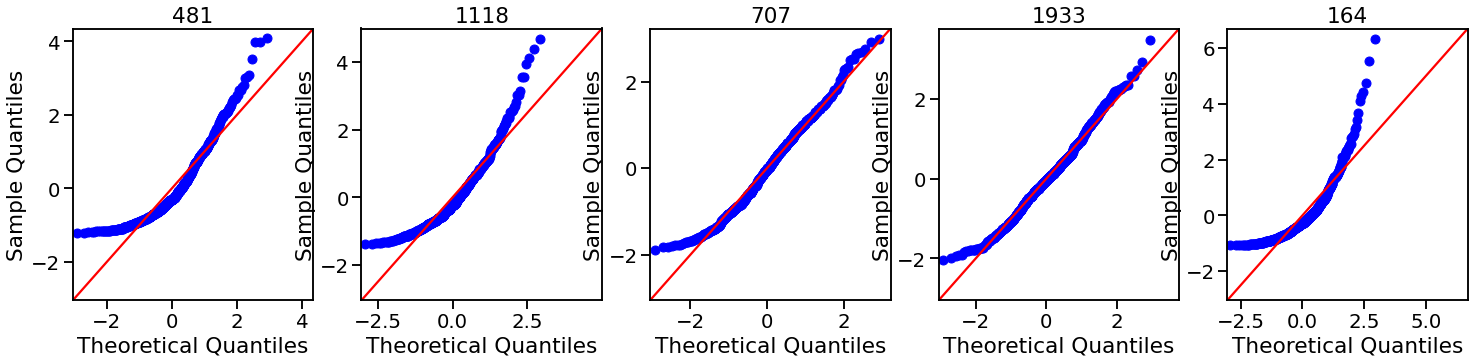

In [74]:
import statsmodels.api as sm

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25,5) )

i=0
for feature in selected.index:
    x = data[data.color == "amarillo"][str(feature)]
    fig1 = sm.qqplot(x,fit=True, line='45', ax=axs[i], scale=5)
    #tats.probplot(x, plot=axs[i])
    axs[i].set_title(feature)
    axs[i].set_aspect('auto')
    i = i+1
 
plt.show()

Como se pudo ver en los resultados del K-S test, las *features* que mas se acercan a una distribución normal son las **707** y la **1933**.

#### Distribución para las **"features"** con ***guantes verdes***:




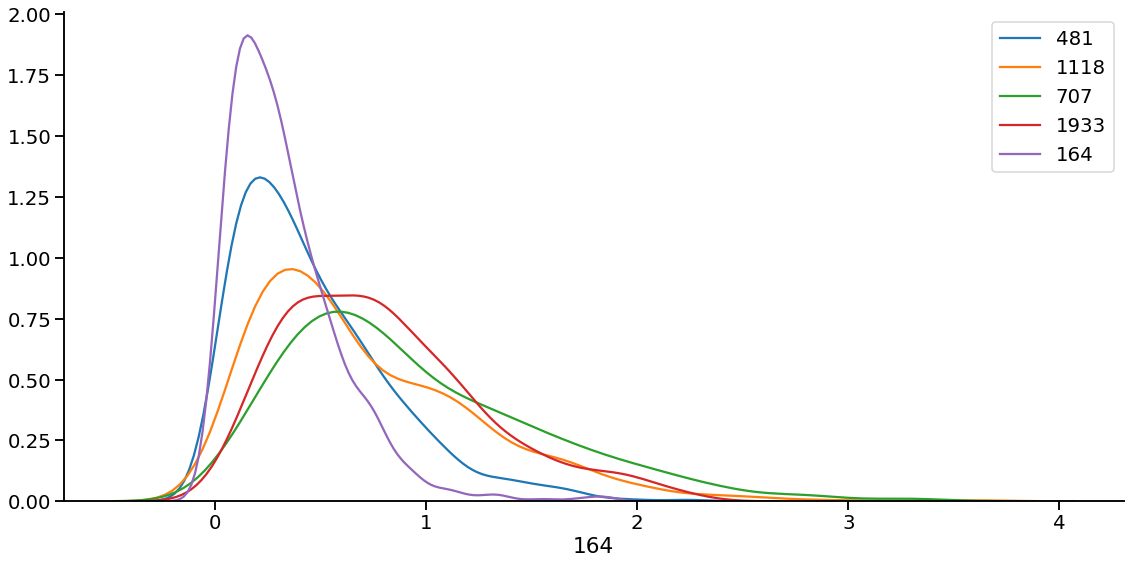

Test Kolmogorv-Smirnov para manos con guantes amarillos


,Feature,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,481,0.107434,2.274078e-07,1.096325,0.0,0.467103,0.364721,688
1,1118,0.126805,4.204369e-10,0.995946,0.0,0.714493,0.528013,688
2,707,0.102227,1.032087e-06,0.989233,0.0,0.931827,0.601642,688
3,1933,0.071301,1.737101e-03,0.969397,0.0,0.793346,0.465683,688
4,164,0.105560,3.953647e-07,1.644403,0.0,0.331390,0.262349,688


In [75]:
k_tests_con_guante = []
plt.figure(figsize=(19,9))
for feature in selected.index:
    x     = data[data.color == "verde"][str(feature)]
    mu    = np.mean( x )
    std   = np.std( x )
    n     = len( x )
    #test  = [ (y - mu)/(std*np.sqrt(n)) for y in x ]
    #Normalizo
    #x_normalizado = preprocessing.normalize([x])
    x_normalizado = x
    mu    = np.mean( x_normalizado )
    std   = np.std(x_normalizado )
    n     = len( x_normalizado )
    sns.distplot(x_normalizado, label=str(feature),  kde=True, hist=False)
    sns.despine()

    #kolmogorv-s
    s, p  = stats.kstest(x_normalizado,'norm',args=(mu,std))
    #s, p  = stats.kstest(x_normalizado,'rayleigh',args=(0,mu))
    
    #Aproximo una mezcla de gaussianas
    gauss_kde    = stats.gaussian_kde(x)

    #Testeo
    s1, p1 = stats.kstest(x,gauss_kde)
    #print( feature, s1, p1 )

    k_tests_con_guante.append( {
        'Feature': str(feature),
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
plt.legend()
plt.show()
k_tests_con_guante_df = pd.DataFrame(k_tests_con_guante)
print("Test Kolmogorv-Smirnov para manos con guantes amarillos")
k_tests_con_guante_df


Viendo los resultados de los p-valores podemos ver que para todas las "features" se puede rechazar la hipotesis nula de que provienen de una distribución normal.

Al igual que las "features" de manos con guantes verdes, podemos analizar los gráficos Q-Q:

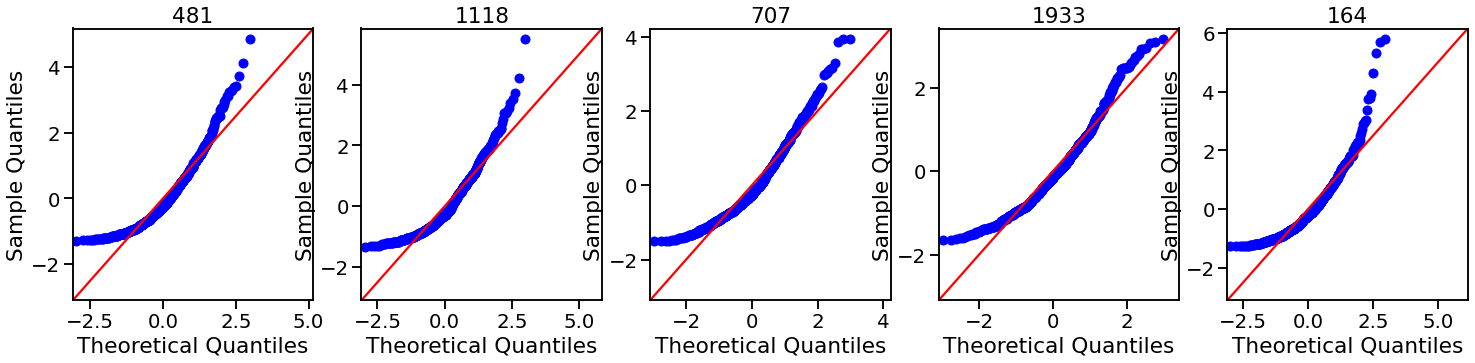

In [76]:

import statsmodels.api as sm

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25,5) )

i=0
for feature in selected.index:
    x = data[data.color == "verde"][str(feature)]
    fig1 = sm.qqplot(x,fit=True, line='45', ax=axs[i], scale=5)
    #tats.probplot(x, plot=axs[i])
    axs[i].set_title(feature)
    axs[i].set_aspect('auto')
    i = i+1
 
plt.show()

Analizando los gráficos se puede corrobar los resultados obtenidos a partir del test K-S, de que las "features" no siguen una distribución normal.